In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import sys
import os

# Add the source directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../source')))

from data_processing import preprocess_data
from feature_selection import select_features_kbest, select_features_from_model
from model_training import train_model, evaluate_model, save_model, load_model

In [58]:
# Adjust path if needed
df = pd.read_csv('C:/Users/nisar/Desktop/Projects/Patient-Risk-Prediction/data/diabetes_risk_prediction_dataset.csv')
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [59]:
# Converting target labels to numeric: 'Negative' -> 0, 'Positive' -> 1
df['class'] = df['class'].map({'Negative': 0, 'Positive': 1})

In [60]:
# Data Preprocessing
X_processed, y, preprocessor = preprocess_data(df.copy()) # Pass a copy to avoid modifying original df

In [61]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (416, 31), y_train shape: (416,)
X_test shape: (104, 31), y_test shape: (104,)


In [62]:
# Feature Selection
X_train_selected, selector_kbest = select_features_kbest(X_train, y_train, k=10)
X_test_selected = selector_kbest.transform(X_test) 

print(f"X_train shape before feature selection: {X_train.shape}")
print(f"X_train shape after feature selection: {X_train_selected.shape}")

X_train shape before feature selection: (416, 31)
X_train shape after feature selection: (416, 10)


In [63]:
# Model Training and Evaluation
models_to_train = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'SVC']
results = {}

for model_name in models_to_train:
    print(f"\n--- Training {model_name} ---")
    model = train_model(X_train_selected, y_train, model_name=model_name)
    metrics = evaluate_model(model, X_test_selected, y_test)
    results[model_name] = metrics
    print(f"{model_name} Metrics: {metrics}")

    # Confusion Matrix
    y_pred = model.predict(X_test_selected)
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

# Results
results_df = pd.DataFrame(results).T
print("\n--- Model Comparison ---")
print(results_df)


--- Training LogisticRegression ---
LogisticRegression Metrics: {'accuracy': 0.8846153846153846, 'precision': 0.90625, 'recall': 0.90625, 'f1_score': 0.90625, 'roc_auc': 0.9732421874999999}
Confusion Matrix:
 [[34  6]
 [ 6 58]]

--- Training DecisionTree ---
DecisionTree Metrics: {'accuracy': 0.9230769230769231, 'precision': 0.9666666666666667, 'recall': 0.90625, 'f1_score': 0.9354838709677419, 'roc_auc': 0.9808593749999999}
Confusion Matrix:
 [[38  2]
 [ 6 58]]

--- Training RandomForest ---
RandomForest Metrics: {'accuracy': 0.9615384615384616, 'precision': 0.96875, 'recall': 0.96875, 'f1_score': 0.96875, 'roc_auc': 0.9798828124999999}
Confusion Matrix:
 [[38  2]
 [ 2 62]]

--- Training SVC ---
SVC Metrics: {'accuracy': 0.9615384615384616, 'precision': 0.96875, 'recall': 0.96875, 'f1_score': 0.96875, 'roc_auc': 0.9740234374999999}
Confusion Matrix:
 [[38  2]
 [ 2 62]]

--- Model Comparison ---
                    accuracy  precision   recall  f1_score   roc_auc
LogisticRegression  0

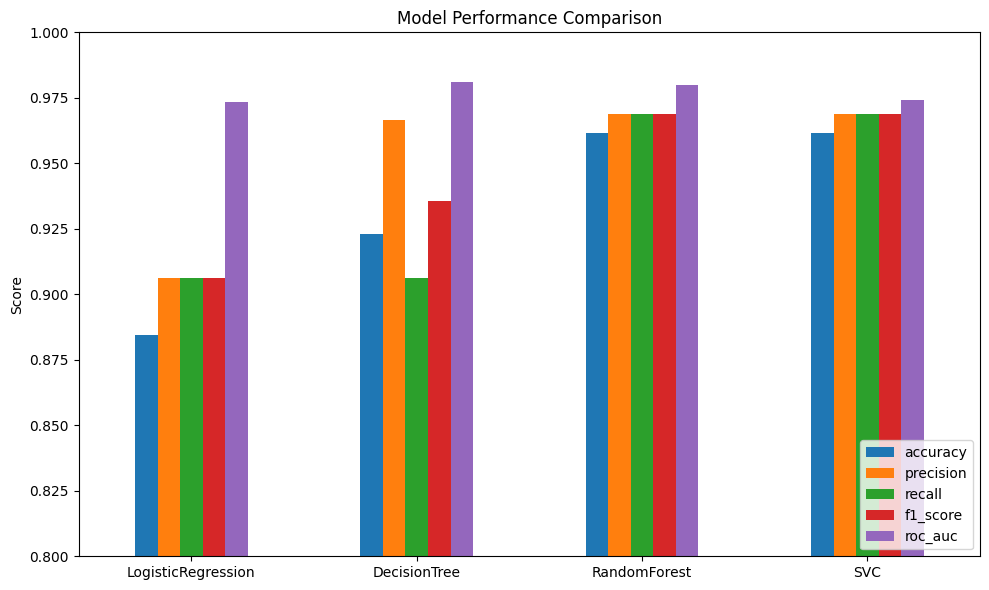

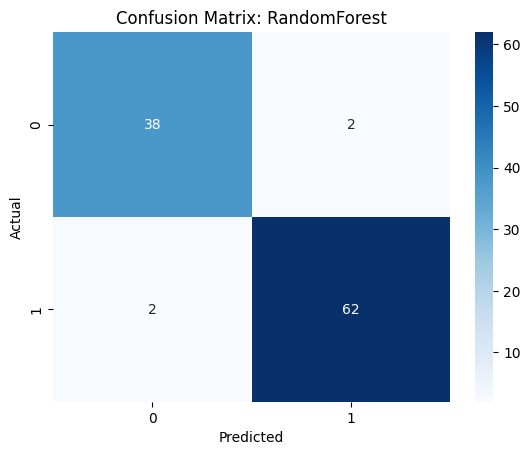

Classification Report for RandomForest:

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        40
           1       0.97      0.97      0.97        64

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104



In [64]:

# Analytics: Summarize and visualize model performance
ax = results_df[metrics_to_plot].plot(kind='bar', figsize=(10, 6))
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=9)
plt.close() 
# Ploting
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
results_df[metrics_to_plot].plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0.8, 1.0)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix: {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification
print(f"Classification Report for {best_model_name}:\n")
print(classification_report(y_test, y_pred))

In [65]:
# Best Model Selection
best_model_name = results_df['f1_score'].idxmax()
print(f"\nBest performing model based on F1-score: {best_model_name}")
final_model = train_model(X_train_selected, y_train, model_name=best_model_name)
save_model(final_model, f'../models/{best_model_name.lower()}_diabetes_predictor.pkl')


Best performing model based on F1-score: RandomForest
Model saved to ../models/randomforest_diabetes_predictor.pkl
